# Self-guided Integrated Grandient Method for Attribution (SIGMA) - Pytorch Implementation

Below is sample code for the torch implementation of SIGMA that will load in an image and model of choice and use the SIGMA method to produce an attribution map. For this example we use the doberman image and InceptionV3 model.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import models
from SIGMA_torch import SIGMA_attribution

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load model and image to be explained

In this example we use InceptionV3

In [2]:
weights = models.Inception_V3_Weights.IMAGENET1K_V1
model = models.inception_v3(weights=weights, aux_logits=True) 
model = model.to(device).eval()

Custom preprocessing function for Pytorch Inception model

In [3]:
def preprocess_fn(img_hwc_0_255: torch.Tensor) -> torch.Tensor:

    x = img_hwc_0_255 / 127.5 - 1.0         
    x = x.permute(2, 0, 1).contiguous()  # CHW
    return x

Choose an image to be explained - this example uses the doberman image

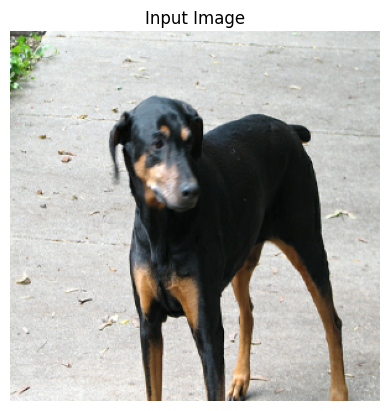

target class: 236
Predicted probability: 0.9575


In [4]:

BASE_DIR = os.getcwd()
target_size = (299, 299)
IMAGE_PATH = os.path.join(BASE_DIR, "sample_images", "doberman.png")


pil_img = Image.open(IMAGE_PATH).convert("RGB").resize(target_size, resample=Image.BILINEAR)
np_img = np.array(pil_img)  

# For display only
plt.imshow(np_img)
plt.title("Input Image")
plt.axis("off")
plt.show()

resized_image = torch.from_numpy(np_img).to(device=device, dtype=torch.float32)  # HWC float32



with torch.no_grad():
    x = preprocess_fn(resized_image).unsqueeze(0)  
    logits = model(x)                              
    probs = torch.softmax(logits, dim=1)

class_idx = int(torch.argmax(probs[0]).item())
probability = float(probs[0, class_idx].item())

print(f"target class: {class_idx}")
print(f"Predicted probability: {probability:.4f}")



### Run SIGMA attribution and visualise 

In [5]:
n_paths = 7
beta = 0.1
alpha = 0.5
epsilon = 0.05
target_class = class_idx

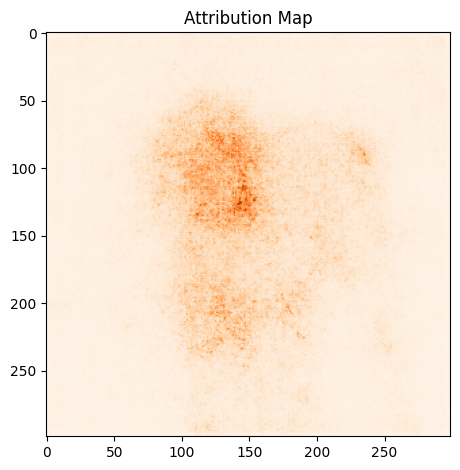

In [7]:
average_attribution_map, error_map, final_img = SIGMA_attribution(
    model=model,
    image=resized_image,
    target_class=target_class,
    n=n_paths,
    beta=beta,
    alpha=alpha,
    epsilon=epsilon,
    preprocess_fn=preprocess_fn
)

avg_map_np = average_attribution_map.detach().cpu().numpy()


# Left: Attribution Map
plt.imshow(avg_map_np, cmap="Oranges")
plt.title("Attribution Map")
plt.tight_layout()
plt.show()